In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install datasets autocorrect optuna sentencepiece transformers torch scikit-learn nltk matplotlib

## Import useful libraries and data

In [ ]:
# imports for the transformer model
import math
from sklearn.model_selection import cross_validate, KFold
from datasets import Dataset
from transformers import AdamW, AutoTokenizer, XLNetForSequenceClassification, XLNetTokenizer, \
    get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup, EvalPrediction
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import classification_report
import random
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
import pickle
from sklearn import svm as Svm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import random
from statistics import mean
import logging
import re
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from functools import reduce
from typing import List, Callable, Dict

warnings.filterwarnings('ignore')
from autocorrect import Speller

spell = Speller(lang='en')
from datasets import load_from_disk
import optuna as op
from sklearn.preprocessing import StandardScaler
import os

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# global variables

cycol = cycle('cmyb')
plt.rcParams['figure.figsize'] = (18, 8)
plt.style.use('ggplot')


SEED = 42  # 42 1337 2022
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english')) - {'not', }
OLD_COLS = [
    'Argument ID', 'Self-direction: thought', 'Self-direction: action', 'Stimulation',
    'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal',
    'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility',
    'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature',
    'Universalism: tolerance', 'Universalism: objectivity',
]
AGAINST = 'against'
IN_FAVOR_OF = 'favor'

CONCOLUSION = 'Conclusion'
STANCE = 'Stance'
PREMISE = 'Premise'
LABELS = 'labels'
CLEAN = 'clean'

BERT_MODEL_NAME = 'bert-base-uncased'
XLNET_MODEL_NAME = 'xlnet-base-cased'


class Path:
    temp = SEED
    SEED = 42
    BASE = os.path.join('drive', 'MyDrive')
    CHECKPOINT = os.path.join(BASE, 'checkpoint')
    MODEL = os.path.join(BASE, f'xlnet_model_{SEED}.pth')
    DATASETS = os.path.join(BASE, "datasets")
    TRAIN = os.path.join(DATASETS, f"train_{SEED}")
    VAL = os.path.join(DATASETS, f"val_{SEED}")
    TEST = os.path.join(DATASETS, f"test_{SEED}")

    TRANSFORMER_MODELS = os.path.join(BASE, "Transformers")
    SVM_MODELS = os.path.join(BASE, "SVM")
    SEED = temp

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Classes & Functions needed throughout the notebook

In [ ]:
class Processor:
    def __init__(self):
        self.preprocessing_pipeline = [
            self.lower,
            self.remove_digits,
            self.replace_special_characters,
            self.replace_br,
            self.filter_out_uncommon_symbols,
            self.remove_stopwords,
            self.correct_spelling,
            self.strip_text,
        ]

    def lower(self, text: str) -> str:
        """
        Transforms given text to lower case.
        """
        return text.lower()

    def replace_special_characters(self, text: str) -> str:
        """
        Replaces special characters, such as paranthesis, with spacing character
        """
        return REPLACE_BY_SPACE_RE.sub(' ', text)

    def remove_digits(self, text: str) -> str:
        """
        Remove digits
        """
        return re.sub('[\d]', '', text)

    def replace_br(self, text: str) -> str:
        """
        Replaces br characters
        """
        return text.replace('br', '')

    def filter_out_uncommon_symbols(self, text: str) -> str:
        """
        Removes any special character that is not in the good symbols list (check regular expression)
        """
        return GOOD_SYMBOLS_RE.sub('', text)

    def remove_stopwords(self, text: str) -> str:
        return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

    def strip_text(self, text: str) -> str:
        """
        Removes any left or right spacing (including carriage return) from text.
        """
        return text.strip()

    def correct_spelling(self, text: str) -> str:
        return spell(text)

    def clean(self, text: str) -> str:
        """
        Applies a list of pre-processing functions in sequence (reduce).
        """
        return reduce(lambda txt, func: func(txt), self.preprocessing_pipeline, text)


def set_seed(seed):
    """
    This function gets a number and sets it as the global seed for 'pytorch', 'numpy' and 'random' libraries.
    This behaviour is nessecary to make sure the result reproducibility is possible.

    :param seed: the number to be set as the global seed.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def create_split(path, split):
    """
    In this function, loads and merges arguments and labels reffering to a given split. 

    :param path: The path to the folder containing the '.tsv' files
    :param split: Either 'train' or  'validation', which indicates which split must get returned.

    :return: A 'DataFrame' object containing the specified split.
    """

    sep = '\t'  # Data is provided as tab-separated values files
    arguments = pd.read_csv(os.path.join(path, 'arguments-' + split + '.tsv'), sep=sep)
    labels = pd.read_csv(os.path.join(path, 'labels-' + split + '.tsv'), sep=sep)
    res = pd.merge(arguments, labels, on='Argument ID')
    res.reset_index(drop=True, inplace=True)
    return res


def get_sorted_target_names(df):
    all_targets = df.columns[4:]
    res = pd.DataFrame(
        {
            'Column': [column for column in all_targets],
            'Frequency': [df[column].value_counts()[1] for column in all_targets]
        }).sort_values(by='Frequency', ascending=False)
    res.reset_index(inplace=True)
    return res['Column']


def transform_dataset(examples, target_names):
    processor = Processor()
    examples[LABELS] = []
    
    examples[CLEAN+CONCOLUSION] = []
    examples[CLEAN+PREMISE] = []

    examples[STANCE+PREMISE] = []
    examples[CLEAN+STANCE+PREMISE] = []
    examples[CONCOLUSION+STANCE+PREMISE] = []
    examples[CLEAN+CONCOLUSION+STANCE+PREMISE] = []

    # There are a lot of duplicate conclusions. We use a dictionary to avoid re-computing clean version of each concolusion.
    concolusion_clean_dict = {}

    for i, (concolusion, premise, stance) in enumerate(
            zip(
                examples[CONCOLUSION],
                examples[PREMISE],
                examples[STANCE]
            )
    ):
        # calculate only in case it is not already calculated.
        clean_concolusion = concolusion_clean_dict.get(concolusion, processor.clean(concolusion))
        clean_premise = processor.clean(premise)
        clean_stance = AGAINST if "against" in stance else IN_FAVOR_OF
        examples[CLEAN+CONCOLUSION].append(clean_concolusion)
        examples[CLEAN+PREMISE].append(clean_premise)
        examples[STANCE+PREMISE].append(' '.join([stance, premise]))
        examples[CLEAN+STANCE+PREMISE].append(' '.join([clean_stance, clean_premise]))
        examples[CONCOLUSION+STANCE+PREMISE].append(' '.join([concolusion, stance, premise]))
        examples[CLEAN+CONCOLUSION+STANCE+PREMISE].append(' '.join([clean_concolusion, clean_stance, clean_premise]))
        examples[LABELS].append([float(examples[target_name][i]) for target_name in target_names])
    return examples


class COLOR:
    PINK = (0.9, 0.1, 0.4, 0.6)
    PURPLE = (0.3, 0.1, 0.4, 0.6)


class Plot:
    def most_frequent_labels_bar_plot(n=20, target_name_list=None):
        assert n <= len(target_name_list), f"number of labels are {len(target_name_list)}, please choose a smaller number for n"
        target_name_list = target_name_list[:n]
        train_target_frequencies = [train[target_name].value_counts()[1] for target_name in target_name_list]
        val_target_frequencies = [val[target_name].value_counts()[1] for target_name in target_name_list]
        plt.figure(figsize=(18,6))
        plt.bar(target_name_list, train_target_frequencies, width = 0.6, color=(0.9, 0.1, 0.4, 0.6), label='Train set')
        plt.bar(target_name_list, val_target_frequencies, width = 0.6, color=(0.3, 0.1, 0.4, 0.6), label='Validation set')
        plt.legend(['Train set', 'Validation set'])
        plt.title('Labels frequency in train and validation', fontsize=15)
        plt.xlabel('Labels')
        plt.xticks(rotation=40, ha='right', rotation_mode='anchor')
        plt.show()
        
    def dict_as_bar(data_dict, target_name_list=None):
        ys = []
        colors = [next(cycol) for i in range(len(data_dict))]
        for key in data_dict:
            x_labels = target_name_list
            ys.append([item[0] for item in data_dict[key].values()])

        # Create the plot, (ax1, ax2)
        fig, (ax1, ax2) = plt.subplots(2, 1)
        for i, y in enumerate(ys):
            ax1.plot(x_labels, y, color=colors[i], label=list(data_dict.keys())[i], linewidth=3)
        bar = ax2.bar(x_labels, [v[1] for v in data_dict[list(data_dict.keys())[0]].values()], color=COLOR.PURPLE)

        # Set x-label and y-label
        ax1.set_xlabel('Labels')
        ax1.set_ylabel('Score')
        ax2.set_xlabel('Labels')
        ax2.set_ylabel('Support')

        # Add x values on top of bars
        for i, rect in enumerate(bar):
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width()/2.0, height, str(height), ha='center', va='bottom')


        # Set xticks with rotation, horizontal alignment, and rotation mode
        ax1.set_xticklabels(x_labels, rotation=40, ha='right', rotation_mode='anchor')
        ax2.set_xticklabels(x_labels, rotation=40, ha='right', rotation_mode='anchor')

        # Set y-axis range
        ax1.set_ylim(0, 1)
        ax2.set_ylim(0, 900)

        # Add legend
        ax1.legend(fontsize=14)
        ax2.legend(fontsize=14)

        # Adjust the height of the gap between the two plots
        fig.subplots_adjust(hspace=0.9)

        # Show plot
        plt.show()

## Train, Val preprocessing and creation

First and for most, let's make the results reproducible by setting the seed to a specific number, `SEED`, defined above.

In [ ]:
set_seed(SEED)

In [ ]:
train = create_split(Path.DATASETS, 'training')
val, test = train_test_split(create_split(Path.DATASETS, 'validation'), test_size=0.5, random_state=SEED)

print(f"Train shape: {train.shape}\nValidation shape: {val.shape}\nTest shape: {test.shape}")

Train shape: (5393, 24)
Validation shape: (948, 24)
Test shape: (948, 24)


In [ ]:
train.iloc[:, 1:4].head()

,Conclusion,Stance,Premise
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,We should ban factory farming,against,factory farming allows for the production of c...


In [ ]:
target_names_sorted = get_sorted_target_names(train)
target_names = train.columns[4:]

In [ ]:
index_of_most_frequent_labels = []
for i in target_names_sorted:
    index_of_most_frequent_labels.append({k: v for k, v in zip(target_names, range(20))}[i])

In [ ]:
try:
    train_dataset = load_from_disk(Path.TRAIN)
    val_dataset = load_from_disk(Path.VAL)
    test_dataset = load_from_disk(Path.TEST)
except FileNotFoundError:
    train_dataset = Dataset.from_pandas(train).map(lambda x: transform_dataset(x, target_names), batched=True,
                                               remove_columns=OLD_COLS)
    val_dataset = Dataset.from_pandas(val).map(lambda x: transform_dataset(x, target_names), batched=True,
                                               remove_columns=OLD_COLS)
    test_dataset = Dataset.from_pandas(test).map(lambda x: transform_dataset(x, target_names), batched=True,
                                               remove_columns=OLD_COLS)
    train_dataset.save_to_disk(Path.TRAIN)
    val_dataset.save_to_disk(Path.VAL)
    test_dataset.save_to_disk(Path.TEST)


In [ ]:
lengths = pd.DataFrame(train_dataset[CONCOLUSION+STANCE+PREMISE])[0].apply(lambda x: x.split(" ")).apply(len)
MAX_LEN = int(lengths.quantile(0.99))
print('99 Percentile of story length is: ', MAX_LEN)

99 Percentile of story length is:  92


## Models

### **SVM**
SVMs are a type of supervised learning algorithm that can be used for classification and regression tasks. They are particularly well-suited for text classification tasks such as human value detection, because they can effectively handle high-dimensional and sparse data, which is typical of text data.

**Optuna** is a Hyperparameter Optimization Framework, we are going to utilise it because it has several advantages over other hyperparameter tuning techniques, **including**:

1. **Efficient sampling**: Optuna uses an efficient sampling algorithm called Tree-structured Parzen Estimator (TPE) that balances exploration and exploitation to quickly find good combinations of hyperparameters.
Pruning: Optuna allows to stop unpromising trials early to save resources. This is particularly useful when tuning expensive models or when working with a large number of hyperparameters.
2. **Distributed optimization**: Optuna allows to perform distributed optimization using distributed optimization libraries, such as Dask, Ray, and Horovod.
3. **Resuming**: Optuna allows to resume paused or interrupted trials, which is useful in cases where the optimization process is interrupted due to hardware failure or other issues.
4. **Study**: Optuna provides the concept of study which allows to keep track of multiple trials and their results. A study can store multiple trials and their results, which can be used to analyze the relationship between different hyperparameters and the performance of the model.
5. **Visualization**: Optuna provides visualization capabilities, such as the Study visualization feature which allows to see the relationship between different hyperparameters and the performance of the model.

#### Model definition

In [ ]:
class SvmModel:
    def __init__(self, n_labels=20, seed=SEED):
        self.n_labels = n_labels
        self.seed = seed
        self.ngram = (1, 2)
        self.n_components = 500
        self.max_featuers = 1000
        self.cv = TfidfVectorizer(ngram_range=self.ngram, max_features=self.max_featuers)
        self.scalar = StandardScaler()
        self.pca = PCA(n_components=self.n_components)
        self.study = op.create_study(direction="maximize")
        self.models = dict()
        self.model = None
        self.train = None
        self.val = None
        self.test = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.y_pred = None
        self.loaded_model = None
        self.scores = None
        set_seed(self.seed)
        self.path = os.path.join(Path.SVM_MODELS, f"{self.seed}_{self.n_labels}.pkl")

        
        self.create_train_val().\
                split_x_y().\
                create_tf_idf().\
                fit_scalar().\
                fit_pca()
        try:
            self.load_model()
        except FileNotFoundError:
            print("Saved file not found. Creating one ...")

            self.find_best_parameters()

            self.create_best_model()

            self.save_model()

            self.predict(self.X_train)
            print(f'F1 score(micro):\nTrain --> {self.compute_f1(self.y_train, self.y_pred.tolist())}')

            self.predict(self.X_val)
            print(f'F1 score(micro):\nVal --> {self.compute_f1(self.y_val, self.y_pred.tolist())}')

            self.predict(self.X_test)
            print(f'F1 score(micro):\nTest --> {self.compute_f1(self.y_test, self.y_pred.tolist())}')

    def create_train_val(self):
        print("Creating train and validation data ...")
        # Create train and validation
        self.train = pd.DataFrame(train_dataset)[[CLEAN+PREMISE, LABELS]]
        self.val = pd.DataFrame(val_dataset)[[CLEAN+PREMISE, LABELS]]
        self.test = pd.DataFrame(test_dataset)[[CLEAN+PREMISE, LABELS]]
        def map_labels(x):
            return [x[i] for i in index_of_most_frequent_labels[:self.n_labels]]
        self.train[LABELS] = self.train[LABELS].apply(map_labels)
        self.val[LABELS] = self.val[LABELS].apply(map_labels)
        self.test[LABELS] = self.test[LABELS].apply(map_labels)

        return self

    def split_x_y(self):
        print("Spliting x and y ...")
        # Create X and y splits
        self.X_train = list(self.train[CLEAN+PREMISE])
        self.X_val = list(self.val[CLEAN+PREMISE])
        self.X_test = list(self.test[CLEAN+PREMISE])
        self.y_train = list(self.train[LABELS])
        self.y_val = list(self.val[LABELS])
        self.y_test = list(self.test[LABELS])

        return self

    def create_tf_idf(self):
        print("Creating tf-idf representation ...")
        # Transform data to their tf_idf representation
        self.X_train = self.cv.fit_transform(self.X_train).toarray()
        self.X_val = self.cv.transform(self.X_val).toarray()
        self.X_test = self.cv.transform(self.X_test).toarray()

        return self

    def fit_scalar(self):
        print("Scaling data ...")
        # Scale X train and val
        self.X_train = self.scalar.fit_transform(self.X_train)
        self.X_val = self.scalar.fit_transform(self.X_val)
        self.X_test = self.scalar.fit_transform(self.X_test)

        return self

    def fit_pca(self):
        print("Reducing dimentionality ...")
        # reduce dementionality of X train and val
        self.X_train = self.pca.fit_transform(self.X_train)
        self.X_val = self.pca.transform(self.X_val)
        self.X_test = self.pca.transform(self.X_test)

        return self

    def objective(self, trial):
        # kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'linear', 'sigmoid'])
        # c = trial.suggest_float("C", 1.0, 30.0, log=True)
        # gamma = trial.suggest_categorical('gamma', ['auto', 'scale'])
        # degree = trial.suggest_int("degree", 1, 3, log=True)
        kernel = trial.suggest_categorical('kernel', ['rbf'])
        c = trial.suggest_float("C", 1.0, 30.0, log=True)
        gamma = trial.suggest_categorical('gamma', ['auto'])
        m = MultiOutputClassifier(Svm.SVC(kernel=kernel, C=c, gamma=gamma, class_weight='balanced'))
        m.fit(self.X_train, self.y_train)
        y_val_pred = m.predict(self.X_val)
        val_f1 = f1_score(self.y_val, y_val_pred.tolist(), average='micro')
        return val_f1

    def find_best_parameters(self):
        print("Finding best parameters ...")
        self.study.optimize(self.objective, n_trials=5, show_progress_bar=True)
        print("Best Parameters found so far:\n{} \n" \
              "with accuracy of : {:.2f} %". \
              format(self.study.best_trial.params, self.study.best_trial.value))

    def visualize_study(self):
        print("Visualizing ...")
        op.visualization.matplotlib.plot_optimization_history(self.study)

    def create_best_model(self):
        print("Creating best model depending on the study ...")
        best_trial = {'kernel': 'rbf', 'C': 1.8924244971368998, 'gamma': 'auto'}
        # self.study.best_trial.params
        self.model = MultiOutputClassifier(Svm.SVC(**best_trial, class_weight='balanced'))
        self.model.fit(self.X_train, self.y_train)

    def predict(self, features=None):
        try:
            if not features:
                features = self.X_test
        except ValueError:
            pass
        print("Predicting ...")
        self.y_pred = self.model.predict(features)

    def compute_f1(self, y_true, y_pred):
        return round(f1_score(y_true, y_pred, average='micro'), 2)

    def save_model(self):
        with open(self.path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)
        print("Model saved.")

    def load_model(self):
        with open(self.path, 'rb') as inp:
            self.loaded_model = pickle.load(inp)
            self.model = self.loaded_model.model
        print("Model loaded.")

#### Seed 42

In [ ]:
svm = SvmModel(seed=42)
svm = svm.loaded_model or svm

[I 2023-04-23 13:52:14,157] A new study created in memory with name: no-name-794ef737-5d06-44aa-9d29-bc71053c507f


Creating train and validation data ...
Spliting x and y ...
Creating tf-idf representation ...
Scaling data ...
Reducing dimentionality ...
Model loaded.


#### Seed 1337

Model loaded.
Visualizing ...
Predicting ...
F1 score(micro):
Train --> 0.96
Predicting ...
F1 score(micro):
Val --> 0.37


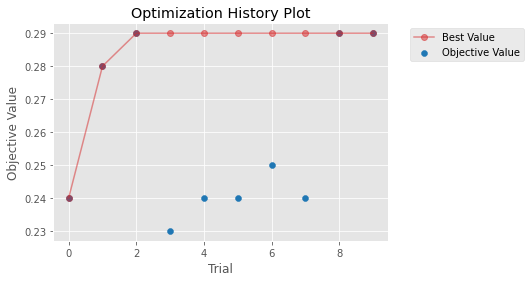

In [ ]:
svm = SvmModel(seed=1337)
svm = svm.loaded_model or svm

#### Seed 2022

Saved file not found. Creating one ...
Creating train and validation data ...
Spliting x and y ...
Creating tf-idf representation ...
Scaling data ...
Reducing dimentionality ...
Finding best parameters ...


  0%|          | 0/10 [00:00<?, ?it/s]

Best Parameters found so far:
{'kernel': 'rbf', 'C': 1.0984200081270612, 'gamma': 'auto'} 
with accuracy of : 0.41 %
Creating best model depending on the study ...
Model saved.
Visualizing ...
Predicting ...
F1 score(micro):
Train --> 0.93
Predicting ...
F1 score(micro):
Val --> 0.39


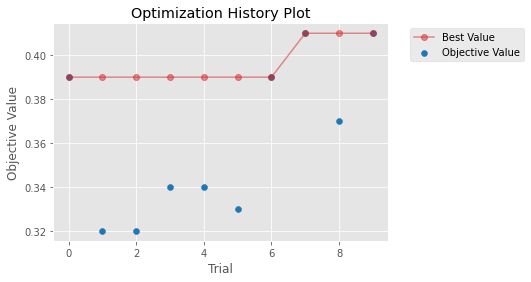

In [ ]:
svm = SvmModel()
svm = svm.loaded_model or svm

### **Transformers**
`XLNet` is a powerful transformer-based model that can be fine-tuned for a wide range of natural language processing (NLP) tasks, including human value detection. There are a few reasons why XLNet may be well-suited for this task:

1. XLNet is trained using a permutation-based training objective, which allows it to better handle the dependencies between words in a sentence, regardless of their order. This makes it well-suited for tasks such as human value detection, where the context can be important from any point in the text.
2. XLNet has been shown to perform well on a wide range of NLP tasks, including sentiment analysis, question answering, and text generation. This suggests that it may be able to learn useful representations of text that can be applied to a wide range of tasks, including human value detection.
3. XLNet has been pre-trained on a large corpus of text, which provides it with a rich understanding of the structure and meaning of natural language. This pre-training can be fine-tuned for a specific task, allowing it to learn task-specific representations from a smaller amount of labeled data.
4. XLNet has been found to be outperforming the BERT model on several NLP task, which makes it a strong candidate for the task of human value detection where the understanding of the context and the ability to generalize is essential.


#### Model Definition

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import Trainer, TrainingArguments
import torch.nn as nn
from time import sleep


def predictions_to_labels(predictions, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs   = sigmoid(torch.Tensor(predictions))
    y_pred  = np.zeros(predictions.shape)
    y_pred[predictions >= threshold] = 1
    return y_pred

def multi_label_metrics(predictions, y_true):
    y_pred = predictions_to_labels(predictions)
    f1_macro_average = f1_score(y_true, y_pred, average='macro')
    f1_micro_average = f1_score(y_true, y_pred, average='micro')

    metrics = {'f1_macro': f1_macro_average, 'f1_micro': f1_micro_average}
    return metrics


class TrasformerModel:
    def __init__(self, model_name, n_labels=20, seed=SEED, batch_size=64, epochs=14):
        self.seed = seed
        self.n_labels = n_labels
        self.batch_size = batch_size
        self.epochs = epochs
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.train = None
        self.val = None
        self.test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.trainer = None
        self.y_pred = None

        set_seed(self.seed)
        self.path = os.path.join(Path.TRANSFORMER_MODELS, str(self.seed), f"{self.model_name}_{self.n_labels}")
        
        try:
            self.download_model_tokenizer(model_path=self.path)
            self.prepare_train_val_test()
            self.create_trainer()
            self.model.eval()
        except (FileNotFoundError, ValueError):
            print("Saved model not found.")
            self.download_model_tokenizer()
            self.prepare_train_val_test()
            self.create_trainer()
            self.train_model()
            self.save_model()

    
    def download_model_tokenizer(self, model_path=None):
        model_name = model_path or self.model_name
        print(f"Gettinng from {model_name} ...")
        if 'xlnet' in self.model_name:
            self.tokenizer = XLNetTokenizer.from_pretrained(model_name)
            self.model = XLNetForSequenceClassification.from_pretrained(model_name,
                                                                        problem_type="multi_label_classification", 
                                                                        num_labels=self.n_labels,
                                                                        )
            
        elif 'bert' in self.model_name:
            self.tokenizer = BertTokenizer.from_pretrained(model_name)
            self.model = BertForSequenceClassification.from_pretrained(model_name,
                                                                        problem_type="multi_label_classification", 
                                                                        num_labels=self.n_labels,
                                                                        )
        else:
            self.tokenizer = None
            self.model = None
            raise NotImplementedError
        return self
    def prepare_input_features(self, examples, tokenizer):
        tokenized_examples = tokenizer(
            examples[CONCOLUSION], 
            examples[STANCE+PREMISE],
            return_tensors='pt',
            padding=True,
            max_length=MAX_LEN,
            truncation=True, )
        tokenized_examples[LABELS] = []
        for labels in examples[LABELS]:
            tokenized_examples[LABELS].append([labels[i] for i in index_of_most_frequent_labels[:self.n_labels]])
        return tokenized_examples

    def prepare_train_val_test(self):
        self.train = train_dataset.map(lambda x: self.prepare_input_features(x, self.tokenizer), batched=True)
        self.train.set_format(type="torch")
        self.val = val_dataset.map(lambda x: self.prepare_input_features(x, self.tokenizer), batched=True)
        self.val.set_format(type="torch")
        self.test = test_dataset.map(lambda x: self.prepare_input_features(x, self.tokenizer), batched=True)
        self.test.set_format(type="torch")

        self.y_train = self.train['labels']
        self.y_val = self.val['labels']
        self.y_test = self.test['labels']

        return self

    def training_arguments(self):
        return TrainingArguments(
            output_dir=Path.CHECKPOINT,
            evaluation_strategy="epoch",
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            warmup_steps=500,
            learning_rate=2e-5,
            num_train_epochs=self.epochs,
            weight_decay=0.01,
            resume_from_checkpoint=True,
            report_to="all"
        )

    def optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=2e-5)
        scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=500, num_training_steps=self.train.shape[0]*self.epochs)
        return optimizer, scheduler

    def compute_metrics(self, p):
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        result = multi_label_metrics(predictions=preds, y_true=p.label_ids)
        return result
    
    def create_trainer(self, ):
        self.trainer = Trainer(
            model=self.model,
            tokenizer=self.tokenizer,
            args=self.training_arguments(),
            compute_metrics=self.compute_metrics,
            train_dataset=self.train,
            eval_dataset=self.val,
            optimizers=self.optimizers(),
        )
        return self

    def train_model(self):
        self.trainer.train()
        return self

    def predict(self, features=None):
        features = features or self.test
        self.y_pred = predictions_to_labels(self.trainer.predict(features).predictions)
        
    def save_model(self):
        self.trainer.save_model(self.path)
        return self

#### 42

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME, seed=42)

Gettinng from drive/MyDrive/Transformers_old/42/bert-base-uncased_20 ...
Saved model not found.
Gettinng from bert-base-uncased ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.633452,0.000000,0.000000
2,No log,0.447557,0.000000,0.000000
3,No log,0.412109,0.000000,0.000000
4,No log,0.392298,0.000000,0.000000
5,No log,0.373072,0.045390,0.102700
6,0.466800,0.360647,0.099531,0.236639
7,0.466800,0.346889,0.120032,0.267923
8,0.466800,0.342604,0.186992,0.342496
9,0.466800,0.337501,0.211652,0.377278
10,0.466800,0.340919,0.251573,0.419462


In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, seed=42)

Gettinng from drive/MyDrive/Transformers/42/xlnet-base-cased_20 ...
Saved model not found.
Gettinng from xlnet-base-cased ...


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.422120,0.000000,0.000000
2,No log,0.406318,0.000000,0.000000
3,No log,0.379891,0.039583,0.093722
4,No log,0.359647,0.104734,0.257307
5,No log,0.346355,0.165645,0.340281
6,0.414800,0.339866,0.206347,0.387483
7,0.414800,0.333413,0.230464,0.402312
8,0.414800,0.331732,0.277780,0.442587
9,0.414800,0.332190,0.299991,0.461208
10,0.414800,0.335851,0.329409,0.486220


#### 1337

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME, seed=1337)

Gettinng from drive/MyDrive/Transformers/1337/bert-base-uncased_20 ...
Saved model not found.
Gettinng from bert-base-uncased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise. If Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 109497620


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.636778,0.143199,0.301791
2,No log,0.441706,0.000000,0.000000
3,No log,0.412481,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise. If Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise. If Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertFo

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.636778,0.143199,0.301791
2,No log,0.441706,0.000000,0.000000
3,No log,0.412481,0.000000,0.000000
4,No log,0.396198,0.017855,0.045143
5,No log,0.377000,0.102639,0.281266
6,0.478000,0.362519,0.130650,0.324377
7,0.478000,0.352233,0.166154,0.360156
8,0.478000,0.343271,0.229774,0.427594
9,0.478000,0.339061,0.262118,0.450000
10,0.478000,0.338694,0.308360,0.479072


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise. If Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise. If Premise, Conclusion, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
Saving model checkpoint to drive/MyDrive/checkpoint/checkpoint-500
The following columns i

In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, seed=1337)

Gettinng from drive/MyDrive/Transformers/1337/xlnet-base-cased_20 ...
Saved model not found.
Gettinng from xlnet-base-cased ...
{'eval_loss': 0.4270331859588623, 'eval_f1_macro': 0.0, 'eval_f1_micro': 0.0, 'eval_runtime': 10.8566, 'eval_samples_per_second': 174.641, 'eval_steps_per_second': 2.763, 'epoch': 1.0}
{'eval_loss': 0.40554001927375793, 'eval_f1_macro': 0.0, 'eval_f1_micro': 0.0, 'eval_runtime': 10.833, 'eval_samples_per_second': 175.021, 'eval_steps_per_second': 2.769, 'epoch': 2.0}
{'eval_loss': 0.38168004155158997, 'eval_f1_macro': 0.05173698331587566, 'eval_f1_micro': 0.12844566315485642, 'eval_runtime': 10.8042, 'eval_samples_per_second': 175.488, 'eval_steps_per_second': 2.777, 'epoch': 3.0}
{'eval_loss': 0.3624367117881775, 'eval_f1_macro': 0.09774501105689636, 'eval_f1_micro': 0.23455637091394263, 'eval_runtime': 10.8436, 'eval_samples_per_second': 174.849, 'eval_steps_per_second': 2.767, 'epoch': 4.0}
{'eval_loss': 0.347963809967041, 'eval_f1_macro': 0.152253173029705

#### 2022

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME, seed=2022)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise. If Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 20
  Instantaneous batch size per device = 80
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 1
  Total optimization steps = 1360
  Number of trainable parameters = 109497620


Epoch,Training Loss,Validation Loss,F1
1,No log,0.664425,0.258665
2,No log,0.484005,0.000000
3,No log,0.426946,0.000000
4,No log,0.407335,0.003450
5,No log,0.393406,0.151397
6,No log,0.377130,0.288845
7,No log,0.362702,0.348513
8,0.465200,0.352535,0.372684
9,0.465200,0.343585,0.410854
10,0.465200,0.341376,0.433366


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise. If Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 80
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise. If Conclusion, Stance, Premise, StancePremise, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 80
The following columns in the evaluation set don't have a corresponding argument in `BertFo

In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, seed=2022)

Gettinng from drive/MyDrive/Transformers/2022/xlnet-base-cased_20 ...
Saved model not found.
Gettinng from xlnet-base-cased ...


PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise. If Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 117324308


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.430348,0.000000,0.000000
2,No log,0.405437,0.000000,0.000000
3,No log,0.380551,0.035066,0.112307
4,No log,0.357796,0.105013,0.262479
5,No log,0.341450,0.159588,0.336039
6,0.415400,0.335527,0.195516,0.380650
7,0.415400,0.331961,0.237941,0.413229
8,0.415400,0.330694,0.272989,0.432011
9,0.415400,0.327811,0.307222,0.459059
10,0.415400,0.336415,0.326910,0.491621


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise. If Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise. If Conclusion, ConclusionStancePremise, Stance, Premise, StancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XL

## Only first 10 most frequent labels

### 1.1 SVM


#### Seed 42

Saved file not found. Creating one ...
Creating train and validation data ...
Spliting x and y ...
Creating tf-idf representation ...
Scaling data ...
Reducing dimentionality ...
Finding best parameters ...


  0%|          | 0/10 [00:00<?, ?it/s]

Best Parameters found so far:
{'kernel': 'rbf', 'C': 1.0433341133433378, 'gamma': 'auto'} 
with accuracy of : 0.46 %
Creating best model depending on the study ...
Model saved.
Visualizing ...
Predicting ...
F1 score(micro):
Train --> 0.93
Predicting ...
F1 score(micro):
Val --> 0.44


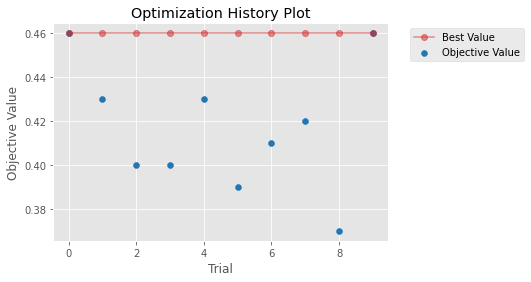

In [ ]:
svm = SvmModel(n_labels=10)
svm = svm.loaded_model or svm
svm.visualize_study()  # visualize steps to toward finding best parameters

#### Seed 1337

Saved file not found. Creating one ...
Creating train and validation data ...
Spliting x and y ...
Creating tf-idf representation ...
Scaling data ...
Reducing dimentionality ...
Finding best parameters ...


  0%|          | 0/10 [00:00<?, ?it/s]

Best Parameters found so far:
{'kernel': 'rbf', 'C': 1.4063610919135634, 'gamma': 'auto'} 
with accuracy of : 0.45 %
Creating best model depending on the study ...
Model saved.
Visualizing ...
Predicting ...
F1 score(micro):
Train --> 0.95
Predicting ...
F1 score(micro):
Val --> 0.43


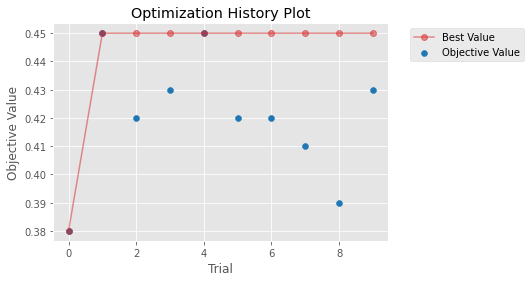

In [ ]:
svm = SvmModel(n_labels=10)
svm = svm.loaded_model or svm
svm.visualize_study()  # visualize steps to toward finding best parameters

#### Seed 2022

Saved file not found. Creating one ...
Creating train and validation data ...
Spliting x and y ...
Creating tf-idf representation ...
Scaling data ...
Reducing dimentionality ...
Finding best parameters ...


  0%|          | 0/10 [00:00<?, ?it/s]

Best Parameters found so far:
{'kernel': 'rbf', 'C': 1.4284811717038934, 'gamma': 'auto'} 
with accuracy of : 0.45 %
Creating best model depending on the study ...
Model saved.
Visualizing ...


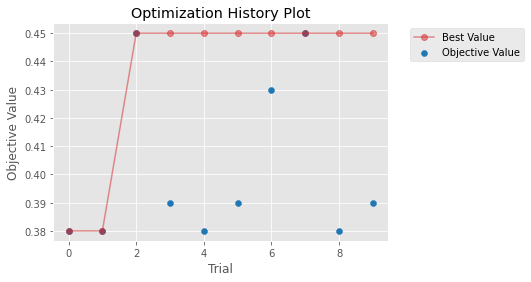

In [ ]:
svm = SvmModel(n_labels=10)
svm = svm.loaded_model or svm
svm.visualize_study()  # visualize steps to toward finding best parameters

### 1.2 Transformers


#### Seed 42

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME,  n_labels=10, seed=42)

Gettinng from drive/MyDrive/Transformers_old/42/bert-base-uncased_10 ...
Saved model not found.
Gettinng from bert-base-uncased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 109489930


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.624851,0.000000,0.000000
2,No log,0.550304,0.000000,0.000000
3,No log,0.521318,0.068734,0.110245
4,No log,0.493911,0.187235,0.278310
5,No log,0.476273,0.262323,0.365730
6,0.534600,0.471814,0.346001,0.435370
7,0.534600,0.466556,0.320429,0.426828
8,0.534600,0.467617,0.390743,0.473677
9,0.534600,0.481453,0.417386,0.491863
10,0.534600,0.487508,0.417635,0.478996


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertFo

In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, n_labels=10, seed=42)

Gettinng from drive/MyDrive/Transformers_old/42/xlnet-base-cased_10 ...
Saved model not found.
Gettinng from xlnet-base-cased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 117316618


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.566253,0.000000,0.000000
2,No log,0.538965,0.016801,0.028667
3,No log,0.504906,0.164124,0.264768
4,No log,0.484670,0.242461,0.352779
5,No log,0.475688,0.305762,0.413459
6,0.510100,0.464961,0.374995,0.459102
7,0.510100,0.477937,0.381342,0.463916
8,0.510100,0.470255,0.418239,0.497163
9,0.510100,0.470501,0.447687,0.510568


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XL

#### Seed 1337

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME,  n_labels=10, seed=1337)

Gettinng from drive/MyDrive/Transformers_old/1337/bert-base-uncased_10 ...
Saved model not found.
Gettinng from bert-base-uncased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 109489930


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.618692,0.006127,0.009921
2,No log,0.554070,0.000000,0.000000
3,No log,0.521409,0.038357,0.072811
4,No log,0.497243,0.186498,0.286412
5,No log,0.477953,0.246791,0.359468
6,0.534200,0.465402,0.295543,0.395397
7,0.534200,0.471383,0.290395,0.375761
8,0.534200,0.466117,0.390221,0.468225
9,0.534200,0.486247,0.410705,0.489111
10,0.534200,0.491425,0.421615,0.499102


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertFo

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.618692,0.006127,0.009921
2,No log,0.554070,0.000000,0.000000
3,No log,0.521409,0.038357,0.072811
4,No log,0.497243,0.186498,0.286412
5,No log,0.477953,0.246791,0.359468
6,0.534200,0.465402,0.295543,0.395397
7,0.534200,0.471383,0.290395,0.375761
8,0.534200,0.466117,0.390221,0.468225
9,0.534200,0.486247,0.410705,0.489111
10,0.534200,0.491425,0.421615,0.499102


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)


Savi

In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, n_labels=10, seed=1337)

Gettinng from drive/MyDrive/Transformers_old/1337/xlnet-base-cased_10 ...
Saved model not found.
Gettinng from xlnet-base-cased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 117316618


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.565245,0.000000,0.000000
2,No log,0.539296,0.000525,0.000802
3,No log,0.509204,0.165520,0.274227
4,No log,0.483005,0.235498,0.344531
5,No log,0.473462,0.318078,0.413598
6,0.510200,0.465395,0.368572,0.450337
7,0.510200,0.468368,0.382202,0.457408
8,0.510200,0.467189,0.409212,0.477520
9,0.510200,0.471187,0.444794,0.505830
10,0.510200,0.486931,0.464070,0.530077


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XL

#### Seed 2022

In [ ]:
bert = TrasformerModel(BERT_MODEL_NAME,  n_labels=10, seed=2022)

In [ ]:
xlnet = TrasformerModel(XLNET_MODEL_NAME, n_labels=10, seed=2022)

Gettinng from drive/MyDrive/Transformers_old/2022/xlnet-base-cased_10 ...
Saved model not found.
Gettinng from xlnet-base-cased ...


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5393
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1190
  Number of trainable parameters = 117316618


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.568446,0.000000,0.000000


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,No log,0.568446,0.000000,0.000000
2,No log,0.541279,0.001131,0.001604
3,No log,0.516625,0.159929,0.264455
4,No log,0.482922,0.237025,0.342036
5,No log,0.478873,0.319798,0.420467
6,0.512800,0.465249,0.345447,0.434930
7,0.512800,0.470410,0.375126,0.452293
8,0.512800,0.470802,0.409901,0.482228
9,0.512800,0.476156,0.453298,0.512046
10,0.512800,0.497706,0.455588,0.522871


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise. If Conclusion, Premise, StancePremise, Stance, ConclusionStancePremise are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1896
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `XL

## Evaluation of the mdoels

In [ ]:
def load_model(n_labels, seed, model_arc):
    if model_arc is 'svm':
        return SvmModel(n_labels=n_labels, seed=seed).loaded_model
    elif model_arc is 'bert':
        return TrasformerModel(BERT_MODEL_NAME, n_labels=n_labels, seed=seed)
    elif model_arc is 'xlnet':
        return TrasformerModel(XLNET_MODEL_NAME, n_labels=n_labels, seed=seed)
    else:
        raise NotImplementedError(f"model_arc: {model_arc} is not implemented.")

def f1_support(y_true, y_pred):
    """
    Calculate the F1 score for each label.

    returns:: list of tuples with length of n_labels: [(f1_score, support), ...]
    """

    label_level_data = []
    label_f1 = f1_score(y_true, y_pred, average=None)
    for label_index in range(y_true.shape[1]):
        label_support = int(sum(y_true[:, label_index]))
        label_level_data.append((round(label_f1[label_index], 2), label_support))
    return label_level_data

def get_metric_data(model_arcs=['svm', 'bert', 'xlnet', 'baseline'], seeds=[42, 1337, 2022], n_labels_list=[20, 10]):
    y_true__y_pred = {}
    for n_labels in n_labels_list:
        y_true__y_pred[n_labels] = {}
        for seed in seeds:
            y_true__y_pred[n_labels][seed] = {}
            for model_arc in model_arcs:
                if model_arc is 'baseline':
                    if seed in [1337, 2022]:
                        continue
                    model = load_model(n_labels, seed, 'bert')
                    y_true = model.y_val
                    y_true__y_pred[n_labels][seed][model_arc] = (y_true, np.ones(shape=y_true.shape))
                else:
                    print(model_arc)
                    model = load_model(n_labels, seed, model_arc)
                    model.predict()
                    y_true = model.y_val
                    y_true = np.array([np.array(t) for t in y_true])
                    y_true__y_pred[n_labels][seed][model_arc] = (y_true, model.y_pred)
    evaluated_results = {
    f"{model_arc}_{n_labels}_{seed}": y_true__y_pred[n_labels][seed][model_arc] \
        for n_labels in y_true__y_pred.keys() \
        for seed in y_true__y_pred[n_labels].keys() \
        for model_arc in y_true__y_pred[n_labels][seed].keys()
    }
    metric_data = dict()
    for k, (y_true, y_pred) in evaluated_results.items():
        metric_data[k] = dict(zip(target_names[:], f1_support(y_true, y_pred)))
    return metric_data

In [ ]:
# model_arcs=['svm', 'bert', 'xlnet'], seeds=[42, 1337, 2022], n_labels_list=[20, 10]
metric_data = get_metric_data(['svm', 'bert', 'xlnet', 'baseline'], [42], [20])

In [ ]:
metric_data.keys()

dict_keys(['svm_20_42', 'bert_20_42', 'xlnet_20_42', 'baseline_20_42'])

In [ ]:
pickle.dump(metric_data, open(os.path.join(Path.BASE,'All_Model_Metrics.pkl'),'wb'))

In [ ]:
metric_data_20 = pickle.load(open(os.path.join(Path.BASE,'All_Model_Metrics.pkl'),'rb'))

### Plots

#### Comparing different seeds applied to each architecture

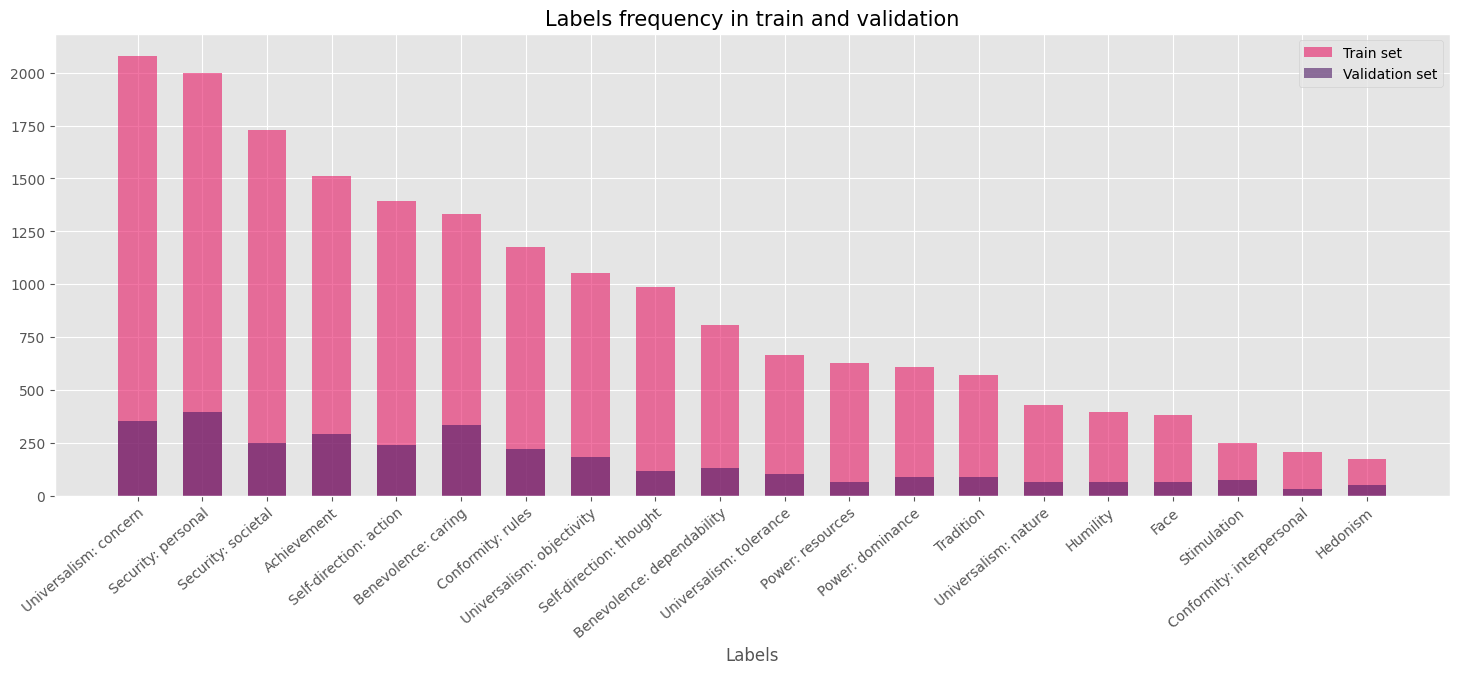

In [ ]:
Plot.most_frequent_labels_bar_plot(target_name_list=target_names_sorted)

In [ ]:
all_svm_models = {k: v for k, v in metric_data.items() if "svm" in k and "20_" in k}
all_bert_models = {k: v for k, v in metric_data.items() if "bert" in k and "20_" in k}
all_xlnet_models = {k: v for k, v in metric_data.items() if "xlnet" in k and "20_" in k}
svm_bert_xlnet_baseline = {k: v for k, v in metric_data.items() if "20_" in k and "_42" in k}
# svm_bert_xlnet_baseline = {k: v for k, v in metric_data.items() if "20_" in k and (("_42" in k and "bert" not in k) or ("_1337" in k and "bert" in k)) }

In [ ]:
all_svm_models = {k: v for k, v in metric_data.items() if "svm" in k and "20_" in k}
all_bert_models = {k: v for k, v in metric_data.items() if "bert" in k and "20_" in k}
all_xlnet_models = {k: v for k, v in metric_data.items() if "xlnet" in k and "20_" in k}
svm_bert_xlnet_baseline = {k: v for k, v in metric_data.items() if "20_" in k and "_42" in k}
# svm_bert_xlnet_baseline = {k: v for k, v in metric_data.items() if "20_" in k and (("_42" in k and "bert" not in k) or ("_1337" in k and "bert" in k)) }

In [ ]:
Plot.dict_as_bar(all_svm_models)

In [ ]:
Plot.dict_as_bar(all_bert_models)

In [ ]:
Plot.dict_as_bar(all_xlnet_models)

Different model archs together

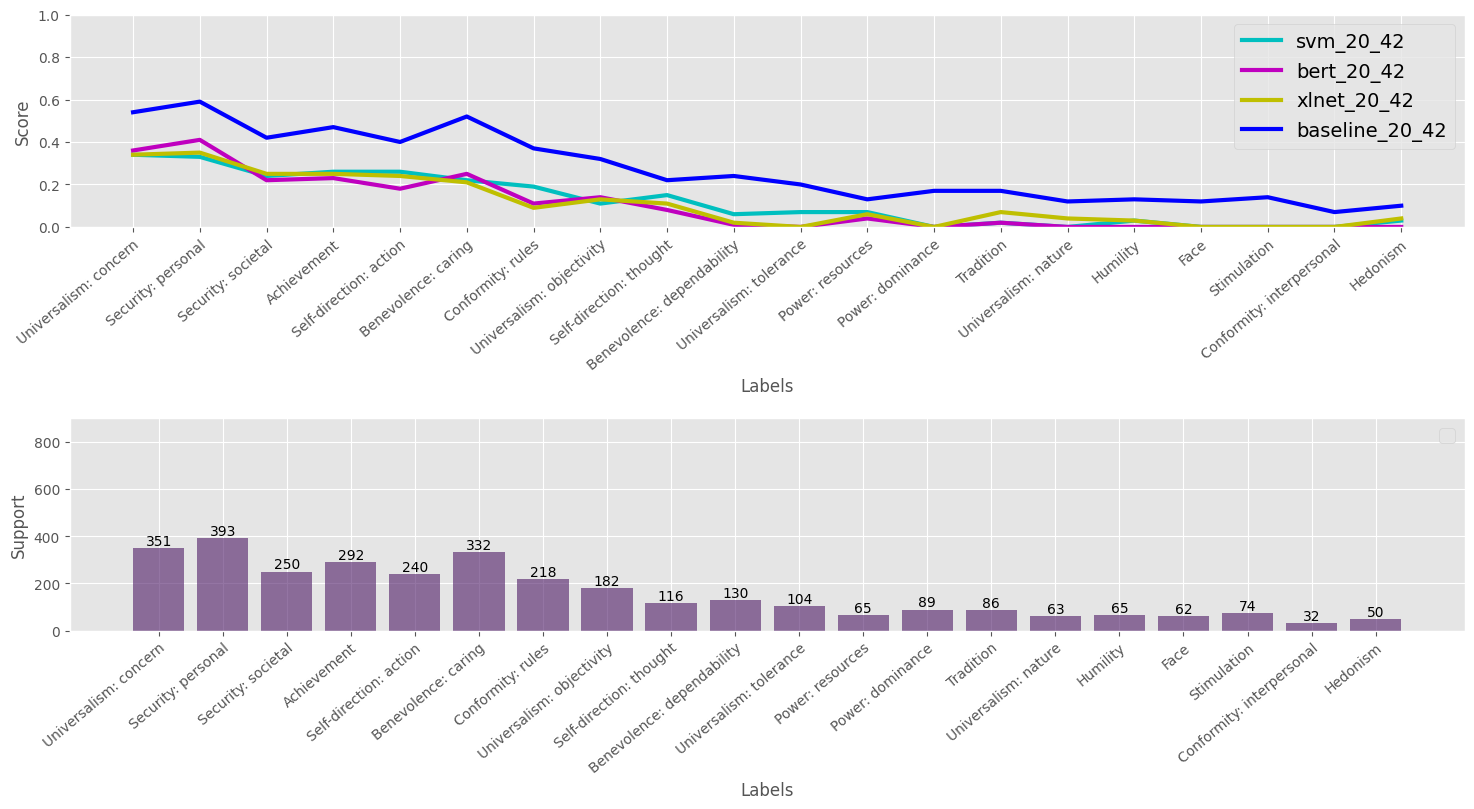

In [ ]:
Plot.dict_as_bar(svm_bert_xlnet_baseline, target_name_list=target_names_sorted)

In [ ]:
Plot.dict_as_bar(svm_bert_xlnet_baseline)

### Plots using 10_label

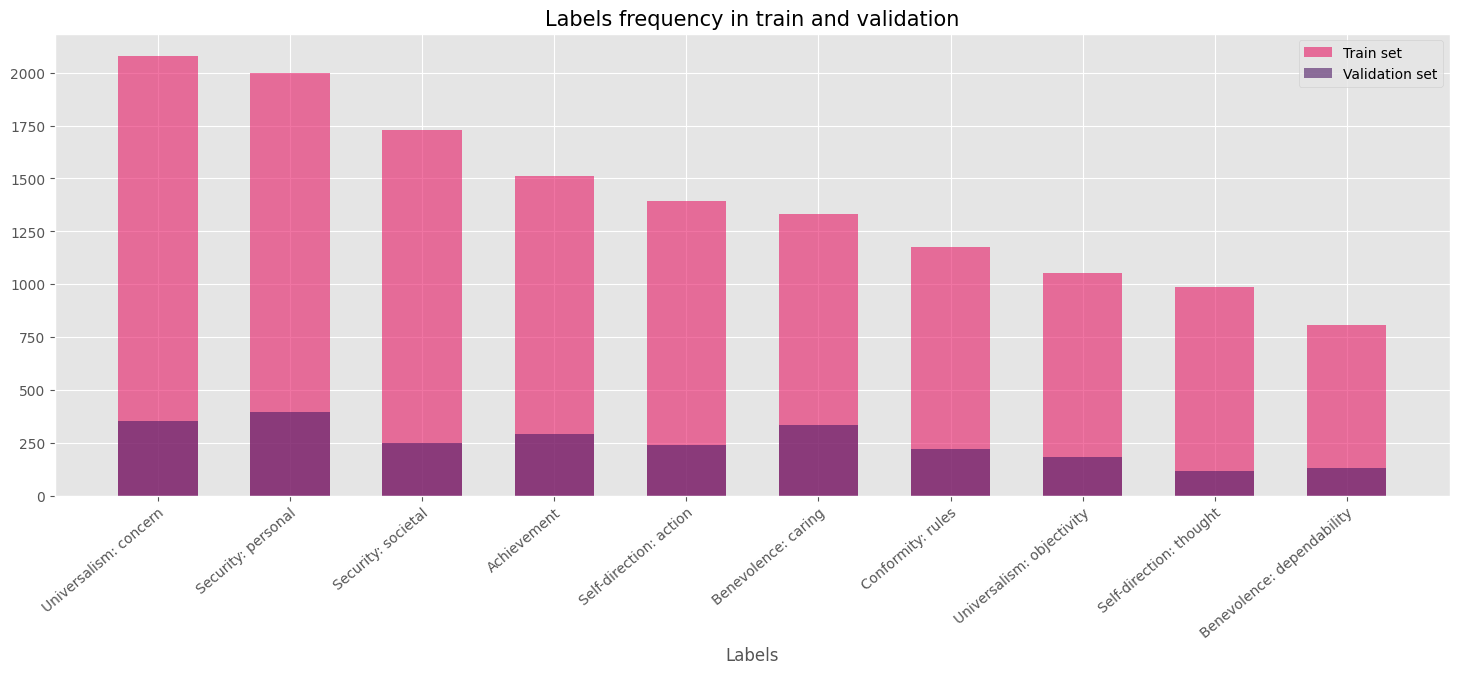

In [ ]:
Plot.most_frequent_labels_bar_plot(10,target_name_list=target_names_sorted)

In [ ]:
metric_data = get_metric_data(['svm', 'bert', 'xlnet', 'baseline'], [42], [10])

In [ ]:
all_svm_models = {k: v for k, v in metric_data.items() if "svm" in k and "10_" in k}
all_bert_models = {k: v for k, v in metric_data.items() if "bert" in k and "10_" in k}
all_xlnet_models = {k: v for k, v in metric_data.items() if "xlnet" in k and "10_" in k}
svm_bert_xlnet_baseline = {k: v for k, v in metric_data.items() if "10_" in k and "_42" in k}

In [ ]:
Plot.dict_as_bar(all_svm_models)

In [ ]:
Plot.dict_as_bar(all_bert_models)

In [ ]:
Plot.dict_as_bar(all_xlnet_models)

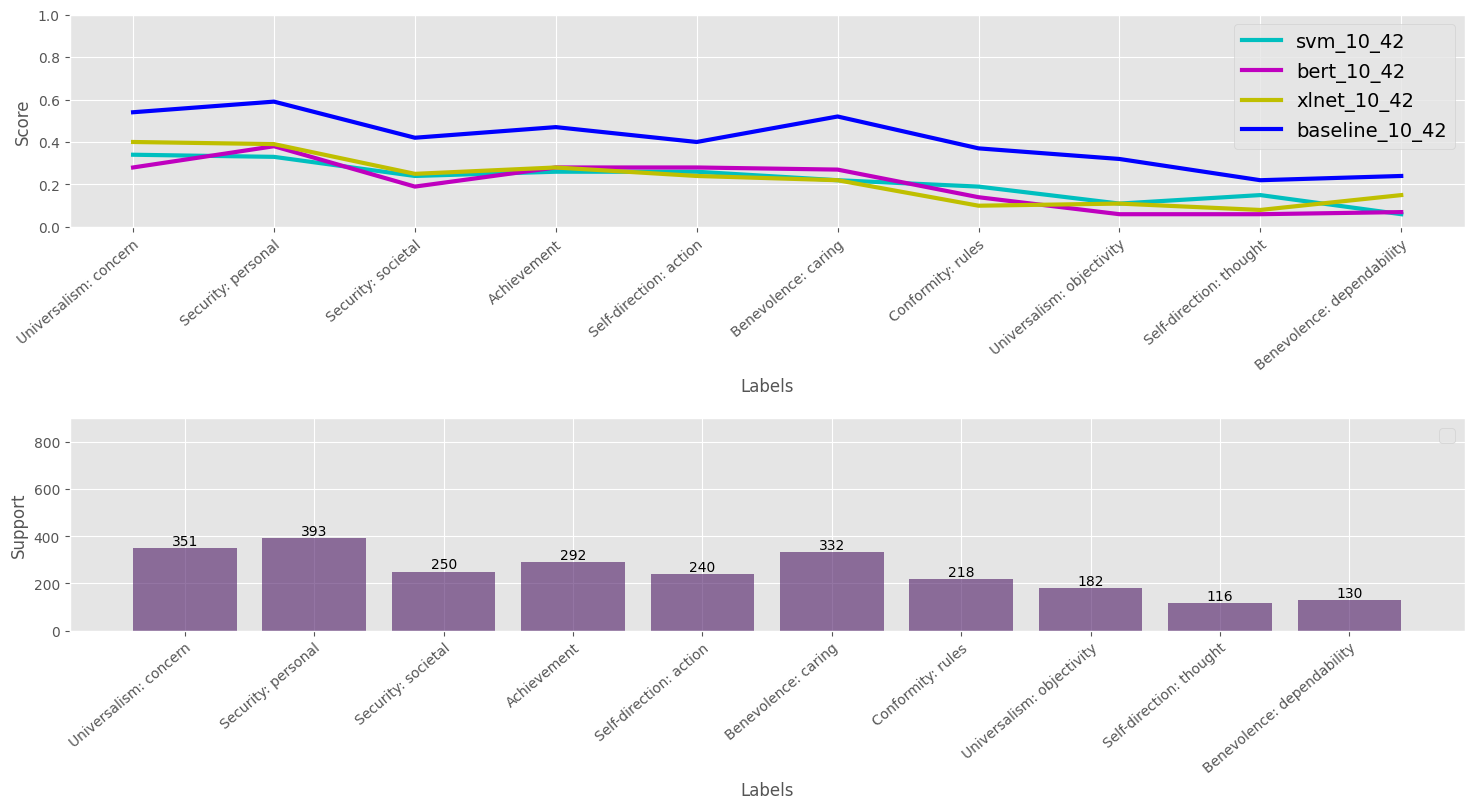

In [ ]:
# metric_data_base.update(svm_bert_xlnet)
Plot.dict_as_bar(svm_bert_xlnet_baseline, target_name_list=target_names_sorted[:10])